In [71]:
%load_ext autoreload
%autoreload 2
import json
from scipy import sparse
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import string
import scipy.stats as stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# We must run scripts on Terrier with the parameters!

### So we run:

* Run the weights and queries in Terrier to get the reuslts file
    - bash rcv1-run-top5-idf-p-alpha.sh and variants (in terrier-core-4.2)
    - bin/trec_terrier.sh -r -Dtrec.model=models.BM25PAlpha  -Dbm25p.p=\$p -Dbm25p.alpha=\$alpha -Dbm25p.w
* Interpret the *.res file and see the position of the correct document for each query
    - bash eval-all.sh which calls
    - python eval-scoring-function-on-query-set-sample.py -i \$FILENAME -o ../results/TerrierOutput/eval/\$BASENAME.txt -t \$QT

# How we do it

#### Scoring functions to evaluate:
    - BM25 
    - BM25P10-top5-idf 
    - BM25P10-top5-tfidf 
    - BM25P10-top10-idf 
    - BM25P10-top10-tfidf

For each scoring function result file we evaluate the 4 query types (A,B,C and D). We have some intermediate files from which we read the position of the corrent doc match. We evaluate if in top 1,10,100.

What are the metrics we are interested in?
- Win/loss ratio
- Average rank
- Precision @ 1,10,100
- MRR

There might be some queries in the input files with no results

In [72]:
def loadJSON(sampleFilename):
    with open(sampleFilename) as json_data:
        sample_10000 = json.load(json_data)
    return sample_10000

## Metrics

In [73]:
def averageRank(rank_list):
    return np.mean(rank_list)

In [74]:
def winLossRatio(rank_list, interval = [0,1]):
    correct_class = [r for r in rank_list if r >= interval[0] and r < interval[1]]
#     print(len(correct_class),len(rank_list))
    if len(correct_class) == len(rank_list): return "-"
    else: return len(correct_class)/(len(rank_list) - len(correct_class))

In [75]:
def precision(rank, at=10):
    n_rel_retrieved = 0
    if rank <= at:
        n_rel_retrieved = 1
    return n_rel_retrieved/at

In [76]:
def avgPrecision(rank_list, at=1):
    prec_list = [precision(r, at) for r in rank_list]
    return np.mean(prec_list)

In [77]:
def MRR(rank_list, at=None):
    if at is not None:
        inverse_ranks = [1./x for x in rank_list if x <= at]
    else:
        inverse_ranks = [1./x for x in rank_list]
#     print(len(rank_list))
    return np.mean(inverse_ranks)

In [78]:
def RR(rank_list, at=None):
    if at is not None:
        inverse_ranks = [1./x for x in rank_list if x <= at]
    else:
        inverse_ranks = [1./x for x in rank_list]
#     print(len(rank_list))
    return inverse_ranks

In [79]:
### http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-24.html

In [80]:
def two_sample_ttest_ind(a,b):
    return stats.ttest_ind(a, b, equal_var=False)

In [81]:
def paired_ttest_rel(a, b):
    return stats.ttest_rel(a, b)

In [82]:
intervals = [[0,1], [1,10], [10,100], [100,1000]]

def getMetrics(ranks, positions, interval):
    print("Avg. rank:", averageRank(ranks))
    print("Win/loss", winLossRatio(positions, interval))
    print("Avg. P@1", avgPrecision(ranks, at=1))
    print("Avg. P@10", avgPrecision(ranks, at=10))
    print("Avg. P@100", avgPrecision(ranks, at=100))
    print("Avg. P@1000", avgPrecision(ranks, at=1000))
    print("MRR", MRR(ranks))

# EVAL 

In [83]:
queryTypes = ["A", "B", "C", "D"]
queryHardness = ["E", "M", "H"]

In [84]:
def getQueryTypeSets(positions):
    A = [x for x in positions if x==0]
    B = [x for x in positions if x>0 and x<10]
    C = [x for x in positions if x>=10 and x<100]
    D = [x for x in positions if x>=100 and x<1000]
    print("A",len(A))
    print("B", len(B))
    print("C",len(C))
    print("D", len(D))

In [85]:
def getQueryTypeSetsInline(positions):
    A = [x for x in positions if x==0]
    B = [x for x in positions if x>0 and x<10]
    C = [x for x in positions if x>=10 and x<100]
    D = [x for x in positions if x>=100 and x<1000]
#     return " , ".join([str(len(A)),str(len(B)),str(len(C)), str(len(D)), str(10000-len(A) -len(B)-len(C)-len(D))])
    return len(A), len(B), len(C), len(D)


### BM25

In [86]:
def evalBM25(filename, qt):
    
    Bm25queryRankDict = loadJSON(filename)

    positions = list(Bm25queryRankDict.values())
    ranks = [x+1 for x in positions]
    
    #pretty print, but no data
    getMetrics(ranks, positions, interval=intervals[queryTypes.index(qt)])
    getQueryTypeSets(positions)
    
    #get some data
    bm25_mrr = MRR(ranks)
    bm25_avg_ranks = np.mean(ranks)
    bm25_query_class = getQueryTypeSetsInline(positions)
#     print(bm25_mrr)
#     print(bm25_query_class)
    
    return bm25_mrr, bm25_avg_ranks, bm25_query_class

In [87]:
hardness_bm25_holder = dict()

for qh in queryHardness:
    print(qh)
    bm25_mrr_dict = dict()
    bm25_avg_rank_dict = dict()
    for qt in queryTypes:
        print(qt)
        filename = "../results/TerrierOutput/eval/BM25P-RCV1-bm25-plain-sample-"+qh+"1000-"+qt+"-p-10-alpha-0.txt"
        print(filename)
        bm25_mrr, bm25_avg_ranks, bm25_query_class = evalBM25(filename, qt)
        bm25_mrr_dict[("bm25-plain", qt)] = bm25_mrr
        bm25_avg_rank_dict[("bm25-plain", qt)] = bm25_avg_ranks
        print()
    hardness_bm25_holder[qh] = (bm25_mrr_dict, bm25_avg_rank_dict)

E
A
../results/TerrierOutput/eval/BM25P-RCV1-bm25-plain-sample-E1000-A-p-10-alpha-0.txt
Avg. rank: 1.0
Win/loss -
Avg. P@1 1.0
Avg. P@10 0.10000000000000002
Avg. P@100 0.01
Avg. P@1000 0.0010000000000000005
MRR 1.0
A 1000
B 0
C 0
D 0

B
../results/TerrierOutput/eval/BM25P-RCV1-bm25-plain-sample-E1000-B-p-10-alpha-0.txt
Avg. rank: 3.907
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.10000000000000002
Avg. P@100 0.01
Avg. P@1000 0.0010000000000000005
MRR 0.3279686507936508
A 0
B 1000
C 0
D 0

C
../results/TerrierOutput/eval/BM25P-RCV1-bm25-plain-sample-E1000-C-p-10-alpha-0.txt
Avg. rank: 38.556
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.0
Avg. P@100 0.01
Avg. P@1000 0.0010000000000000005
MRR 0.038431823907310016
A 0
B 0
C 1000
D 0

D
../results/TerrierOutput/eval/BM25P-RCV1-bm25-plain-sample-E1000-D-p-10-alpha-0.txt
Avg. rank: 355.451
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.0
Avg. P@100 0.0
Avg. P@1000 0.0010000000000000005
MRR 0.004286420238034458
A 0
B 0
C 0
D 1000

M
A
../results/TerrierOutput/eval/BM25P-R

In [88]:
for k, (bm25_mrr_dict, bm25_avg_rank_dict) in hardness_bm25_holder.items():
    print("Hardness: " , k)
    print("MRR: ", bm25_mrr_dict)
    print("Avg. Rank: ", np.mean(list(bm25_avg_rank_dict.values())))
    print("Avg. Rank per group: ", bm25_avg_rank_dict)
    print()

Hardness:  E
MRR:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 0.3279686507936508, ('bm25-plain', 'C'): 0.038431823907310016, ('bm25-plain', 'D'): 0.004286420238034458}
Avg. Rank:  99.7285
Avg. Rank per group:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 3.907, ('bm25-plain', 'C'): 38.556, ('bm25-plain', 'D'): 355.451}

Hardness:  M
MRR:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 0.32030912698412706, ('bm25-plain', 'C'): 0.03829019497046958, ('bm25-plain', 'D'): 0.0044842629900549175}
Avg. Rank:  91.25325000000001
Avg. Rank per group:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 4.02, ('bm25-plain', 'C'): 38.873, ('bm25-plain', 'D'): 321.12}

Hardness:  H
MRR:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 0.3336579365079365, ('bm25-plain', 'C'): 0.038582203907635886, ('bm25-plain', 'D'): 0.004189940606836789}
Avg. Rank:  97.58125
Avg. Rank per group:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 3.844, ('bm25-plain', 'C'): 37.394, ('bm25-plain', 'D'): 348.087}



Hardness:  E
MRR:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 0.31209484126984127, ('bm25-plain', 'C'): 0.039714221055264606, ('bm25-plain', 'D'): 0.004160977524092354}
Avg. Rank:  100.40675
Avg. Rank per group:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 4.144, ('bm25-plain', 'C'): 36.666, ('bm25-plain', 'D'): 359.817}

Hardness:  M
MRR:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 0.32182301587301587, ('bm25-plain', 'C'): 0.039027292356970424, ('bm25-plain', 'D'): 0.004373947432865377}
Avg. Rank:  94.04625
Avg. Rank per group:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 3.962, ('bm25-plain', 'C'): 38.308, ('bm25-plain', 'D'): 332.915}

Hardness:  H
MRR:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 0.3186126984126984, ('bm25-plain', 'C'): 0.03897693139022743, ('bm25-plain', 'D'): 0.0043118100866549195}
Avg. Rank:  96.15424999999999
Avg. Rank per group:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 4.089, ('bm25-plain', 'C'): 38.265, ('bm25-plain', 'D'): 341.263}

### BM25P 

In [89]:
# Settings
dirEval = "../results/TerrierOutput/eval/"
baseTypes = ["top5-idf", 
             "top5-tfidf",
             "top10-idf",
             "top10-tfidf"]
queryTypes = ["A", "B", "C", "D"]
queryHardness = ["E", "M", "H"]
ending = ".txt" # sometimes res

### MRR plots for different alpha

In [90]:
import os

def get_stats_by_hardness(hardness):
    mrr_dict = defaultdict(list)
    rr_dict = defaultdict(list)
    average_rank_dict = defaultdict(list)

    for filename in os.listdir(dirEval):
        name_items = filename.split("-")
    #     print(name_items)
        if name_items[5] == hardness+"1000": 
            baseType = name_items[2]+"-"+name_items[3]
            alpha = filename.split(".")[0].split("-")[10]


            queryRankDict = loadJSON(dirEval+filename)
            positions = list(queryRankDict.values())
            ranks = [x+1 for x in positions]
            mrr_dict[(baseType, name_items[6])].append(((int(alpha)), MRR(ranks)))
            rr_dict[(baseType, name_items[6])].append(((int(alpha)), RR(ranks)))
            average_rank_dict[(baseType, name_items[6])].append(((int(alpha)), np.mean(ranks)))
    return mrr_dict, rr_dict, average_rank_dict

In [91]:
def plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes):
    for queryType in queryTypes:
        key = (baseType, queryType)
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
#         print(x)
#         print(y)
        plt.plot(x,y , label=key)
        #print(max(y),x[y.index(max(y))])
        plt.plot(x[y.index(max(y))], max(y), "or")
        # print bm25 as baseline
        baseline_y = [bm25_mrr_dict[("bm25-plain", queryType)]] * len(x)
#         print(baseline_y)
        plt.plot(x, baseline_y, label="('bm25-plain', " + str(queryType)+ "')", linestyle="--")
#         print()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("BM25P varying alpha")
    plt.xlabel("Alpha")
    plt.ylabel("MRR@1000")
#     plt.axis([5,25,0,20]) # this is for zooming in
    plt.show()
    return plt

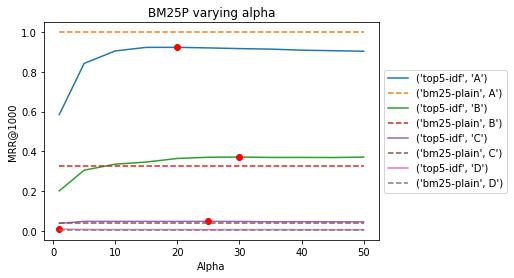

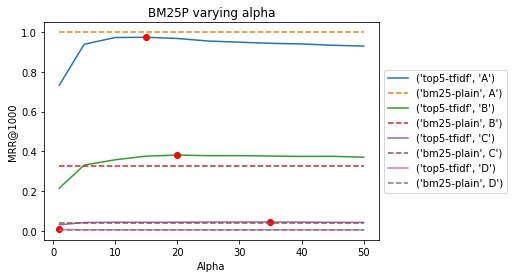

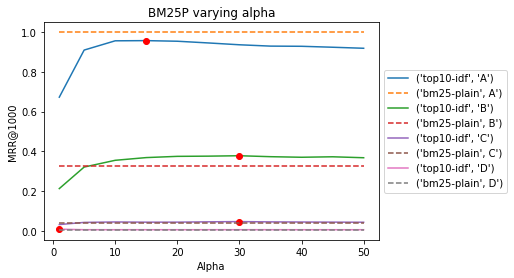

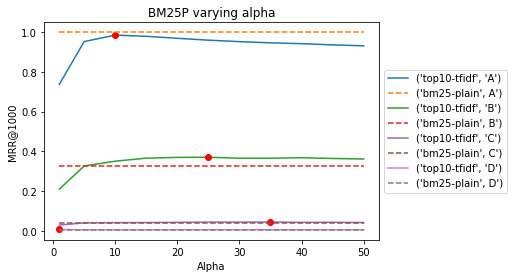

In [92]:
bm25_mrr_dict = hardness_bm25_holder["E"][0]
mrr_dict, rr_dict, average_rank_dict = get_stats_by_hardness("E")

for baseType in baseTypes:
    plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes)

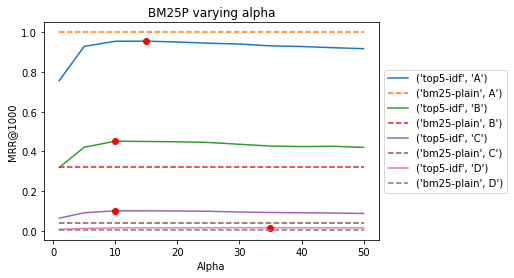

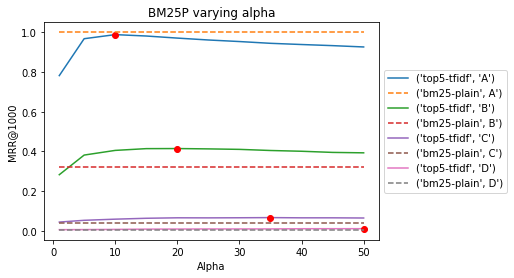

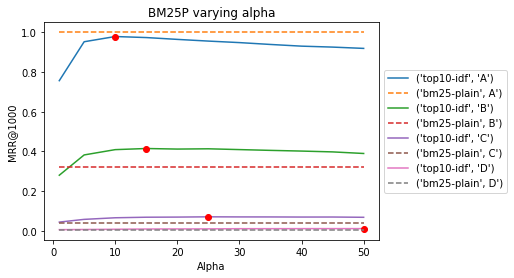

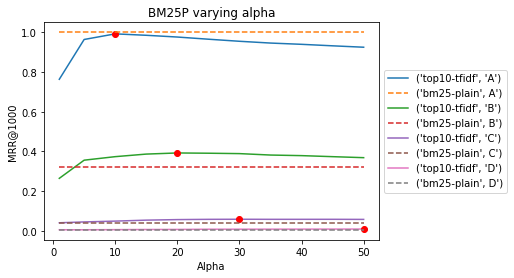

In [93]:
bm25_mrr_dict = hardness_bm25_holder["M"][0]
mrr_dict, rr_dict, average_rank_dict = get_stats_by_hardness("M")

for baseType in baseTypes:
    plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes)

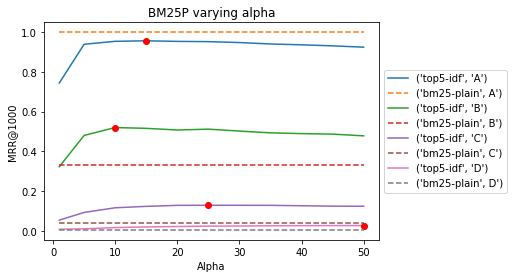

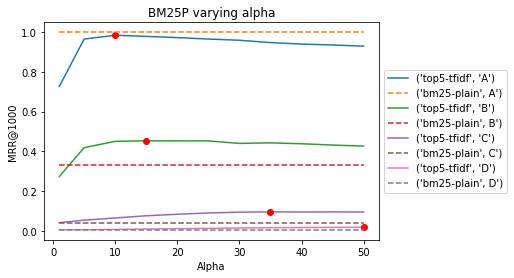

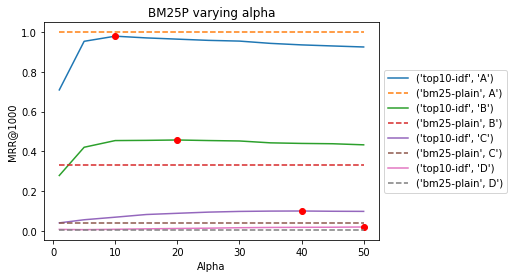

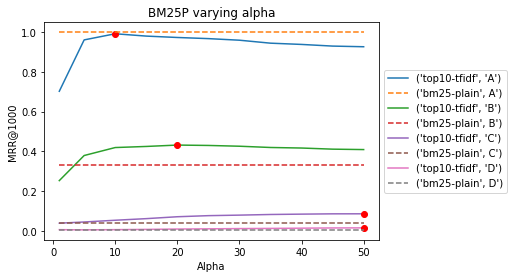

In [94]:
bm25_mrr_dict = hardness_bm25_holder["H"][0]
mrr_dict, rr_dict, average_rank_dict = get_stats_by_hardness("H")

for baseType in baseTypes:
    plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes)

# Average RANK 

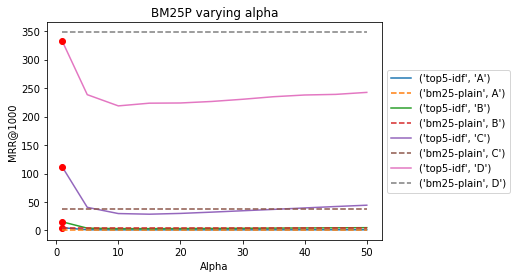

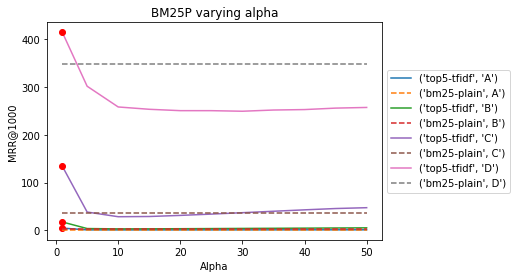

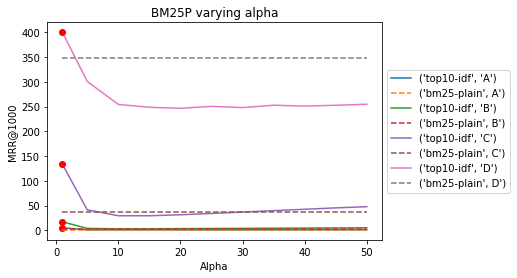

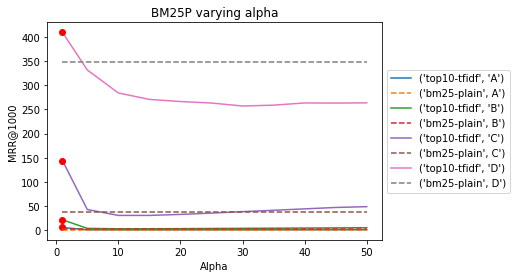

In [107]:
bm25_avg_rank_dict = hardness_bm25_holder["H"][1]
mrr_dict, rr_dict, average_rank_dict = get_stats_by_hardness("H")

for baseType in baseTypes:
    a = plot_and_sort(baseType, average_rank_dict, bm25_avg_rank_dict, queryTypes)

In [108]:
for baseType in baseTypes:

    for queryType in queryTypes:
        key = (baseType, queryType)
        avg_rank_list = average_rank_dict[key]
        x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]

        avg_rank_bm25 = bm25_avg_rank_dict[("bm25-plain", queryType)]
        #for i in range(len(y)):
        for i in [2,3,4,5,6]:
            
            print("\x1b[0m "+str(key), x[i], y[i], avg_rank_bm25, end='')
            print("\x1b[31m WIN" if y[i]<avg_rank_bm25 else "\x1b[0m ") 
        print()
        
    print("--------------------------------")

 ('top5-idf', 'A') 10 1.124 1.0 
 ('top5-idf', 'A') 15 1.11 1.0 
 ('top5-idf', 'A') 20 1.118 1.0 
 ('top5-idf', 'A') 25 1.128 1.0 
 ('top5-idf', 'A') 30 1.152 1.0 

 ('top5-idf', 'B') 10 3.278 3.844 WIN
 ('top5-idf', 'B') 15 3.298 3.844 WIN
 ('top5-idf', 'B') 20 3.46 3.844 WIN
 ('top5-idf', 'B') 25 3.636 3.844 WIN
 ('top5-idf', 'B') 30 3.888 3.844 

 ('top5-idf', 'C') 10 29.726 37.394 WIN
 ('top5-idf', 'C') 15 28.61 37.394 WIN
 ('top5-idf', 'C') 20 29.978 37.394 WIN
 ('top5-idf', 'C') 25 32.21 37.394 WIN
 ('top5-idf', 'C') 30 34.643 37.394 WIN

 ('top5-idf', 'D') 10 218.77473684210526 348.087 WIN
 ('top5-idf', 'D') 15 223.52971845672576 348.087 WIN
 ('top5-idf', 'D') 20 223.88210526315788 348.087 WIN
 ('top5-idf', 'D') 25 226.52386002120892 348.087 WIN
 ('top5-idf', 'D') 30 230.3895410885806 348.087 WIN

--------------------------------
 ('top5-tfidf', 'A') 10 1.031 1.0 
 ('top5-tfidf', 'A') 15 1.045 1.0 
 ('top5-tfidf', 'A') 20 1.063 1.0 
 ('top5-tfidf', 'A') 25 1.086 1.0 
 ('top5-tfi

In [109]:
print("BM25 avg rank :", np.mean(list(bm25_avg_rank_dict.values())))

for baseType in baseTypes:
    all_avg_rank = np.zeros(11)
    for queryType in queryTypes:
        key = (baseType, queryType)
#         print(key)
        avg_rank_list = average_rank_dict[key]
        x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        all_avg_rank += np.array(y)
#         print(x)
#         print(y)
#         print(all_avg_rank)
    print()
    print(baseType+ " avg rank[1-50] : ", all_avg_rank/4)

BM25 avg rank : 97.58125

top5-idf avg rank[1-50] :  [115.75316233  71.11610018  63.22568421  64.13692961  64.60952632
  65.87446501  67.51813527  69.32028598  70.7740671   71.74299782
  73.26764874]

top5-tfidf avg rank[1-50] :  [142.6730582   86.1507738   72.68285152  71.62573904  71.53856736
  72.29031335  72.81211497  74.27708784  75.33486761  76.87581718
  77.74582232]

top10-idf avg rank[1-50] :  [139.02303257  86.79914599  72.03445492  70.61410123  70.6510625
  72.35211345  72.52266667  74.51900215  74.85110383  76.04606725
  77.27074834]

top10-tfidf avg rank[1-50] :  [145.3995541   94.97637327  79.77541331  76.48774848  75.95998196
  75.9647542   75.27277712  76.48776656  78.45727293  79.18518433
  79.82305316]



# Statistical significance for MRR values

In [33]:
print(rr_dict.keys())

dict_keys([('top5-tfidf', 'A'), ('top5-idf', 'A'), ('top5-tfidf', 'C'), ('top10-idf', 'B'), ('top10-tfidf', 'A'), ('top5-tfidf', 'D'), ('top10-idf', 'C'), ('top10-tfidf', 'C'), ('top5-tfidf', 'B'), ('top5-idf', 'D'), ('bm25-plain', 'A'), ('top5-idf', 'B'), ('top10-tfidf', 'D'), ('top10-tfidf', 'B'), ('top10-idf', 'A'), ('top10-idf', 'D'), ('top5-idf', 'C'), ('bm25-plain', 'B'), ('bm25-plain', 'D'), ('bm25-plain', 'C')])


## two pample paired - IND

In [34]:
def check_statistical_significance(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
        
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        max_index = x[y.index(max(y))]
        
        for first, second in zip(sorted_rr_list, sorted_rr_list[1:]):
            print(first[0], second[0])
            print(y[x.index(first[0])], y[x.index(second[0])])
            print(two_sample_ttest_ind(first[1], second[1]))

In [35]:
def check_statistical_significance_with_max(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
        
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        max_alpha = x[y.index(max(y))]
        print(max_alpha)
        max_rrs = sorted_rr_list[x.index(max_alpha)][1]
        
        for first in sorted_rr_list:
            print(first[0], max_alpha)
            print(y[x.index(first[0])], y[x.index(max_alpha)])
            print(two_sample_ttest_ind(first[1], max_rrs))

In [ ]:
check_statistical_significance_with_max('top5-idf', rr_dict, mrr_dict, queryTypes)

In [ ]:
for baseType in baseTypes:
    check_statistical_significance_with_max(baseType, rr_dict, mrr_dict, queryTypes)

# T-test for 2 related sample scores
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel

In [40]:
def check_statistical_significance_with_baseline(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
#         print(sorted_rr_list) # list of (alpha, rr_list)
#         print([x for x,y in sorted_rr_list])
        
        
        base_rr_list = rr_dict[("bm25-plain", queryType)]
        sorted_base_rr_list = sorted(base_rr_list, key=lambda tup: tup[0])
#         print(sorted_base_rr_list) # list of (alpha, rr_list) 
#         print([x for x,y in sorted_base_rr_list])
        

        
        for first in sorted_rr_list:
            print(first[0], sorted_base_rr_list[0][0])
            print(np.mean(first[1]), np.mean(sorted_base_rr_list[0][1]))
            print(two_sample_ttest_ind(first[1], sorted_base_rr_list[0][1]))

In [ ]:
check_statistical_significance_with_baseline('top5-idf', rr_dict, mrr_dict, queryTypes)

#### ALL are statistically different!!!

### WIN/LOSS ratio for varying alpha

In [53]:
import os

class_dict = defaultdict(list)
for filename in os.listdir(dirEval):
    name_items = filename.split("-")
    baseType = name_items[2]+"-"+name_items[3]
    alpha = filename.split(".")[0].split("-")[10]
    
    queryRankDict = loadJSON(dirEval+filename)
    positions = list(queryRankDict.values())
    ranks = [x+1 for x in positions]
    new_class = getQueryTypeSetsInline(positions)
    class_dict[(baseType, name_items[6])].append(((int(alpha)), new_class))

In [54]:
def getWinLossRatio(baseType, queryType, alpha, class_dict):
    line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
    if queryType == "A":
        losses = sum(line[1][1:])
        wins = []
        for queryType in ["B","C","D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][0])
        return sum(wins)/losses
    if queryType == "B":
        losses = sum(line[1][2:])
        wins = []
        for queryType in ["C","D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][1])
        return sum(wins)/losses
    if queryType == "C":
        losses = sum(line[1][3:])
        wins = []
        for queryType in ["D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][2])
        return sum(wins)/losses
        

In [55]:
getWinLossRatio("top5-tfidf", "C", 10, class_dict)

5.669456066945607

In [56]:
win_loss_dict = defaultdict(list) ### the list contains WL for multiple alpha

for baseType in baseTypes:
    for queryType in queryTypes:
        if queryType is not "D":
            for alpha,_ in class_dict[(baseType, queryType)]:
                wl = getWinLossRatio(baseType, queryType, alpha, class_dict)
                win_loss_dict[(baseType, queryType)].append(((int(alpha)), wl))

In [57]:
print(win_loss_dict)

defaultdict(<class 'list'>, {('top5-idf', 'A'): [(20, 2.015655577299413), (40, 1.5544554455445545), (1, 0.27850283181482394), (50, 1.4104166666666667), (30, 1.7611301369863013), (35, 1.684596577017115), (45, 1.4742193173565723), (25, 1.8652094717668488), (10, 1.6786632390745502), (15, 1.9657869012707723), (5, 1.0797101449275361)], ('top5-idf', 'B'): [(50, 1.62015503875969), (30, 2.32776617954071), (20, 2.880050505050505), (45, 1.756198347107438), (25, 2.6039260969976907), (15, 3.1966987620357634), (10, 2.844932844932845), (40, 1.8915343915343916), (1, 0.3241398143091207), (5, 1.5195086705202312), (35, 2.0636882129277567)], ('top5-idf', 'C'): [(5, 1.9134532990574122), (45, 1.4040178571428572), (30, 1.9396551724137931), (50, 1.3111268603827073), (1, 0.4286694101508916), (10, 2.9610894941634243), (20, 2.6649810366624527), (40, 1.5161799526440412), (35, 1.697934595524957), (25, 2.211087420042644), (15, 3.095435684647303)], ('top5-tfidf', 'A'): [(1, 0.221395881006865), (5, 1.212871287128712

In [58]:
def plot_and_sort_WL(baseType, win_loss_dict, queryTypes):
    for queryType in ["A","B","C"]:
        key = (baseType, queryType)
        wl_list = win_loss_dict[key]
#         print(key)
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(wl_list, key=lambda tup: tup[0])]
#         print(x)
        y = [y for x,y in sorted(wl_list, key=lambda tup: tup[0])]
#         print(y)
        plt.plot(x, y , label=key)
        #print(max(y),x[y.index(max(y))])
        plt.plot(x[y.index(max(y))], max(y), "or")
    plt.plot(x, [1 for x in range(len(x))], ":k", label="win-loss threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("BM25P varying alpha")
    plt.xlabel("Alpha")
    plt.ylabel("WinLossRatio")
    plt.show()

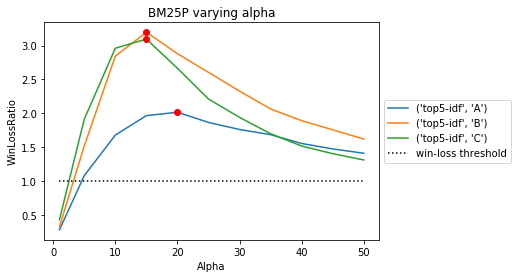

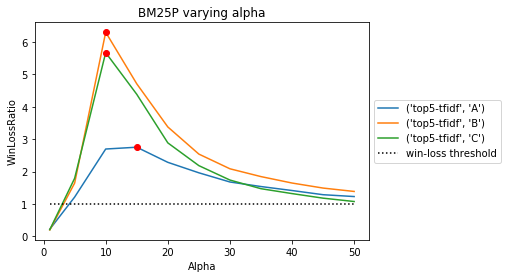

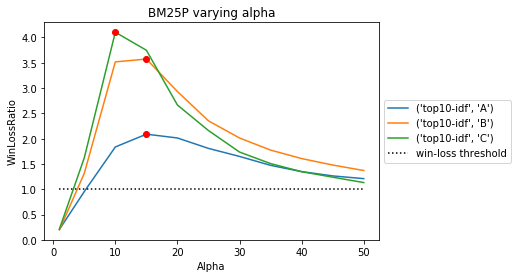

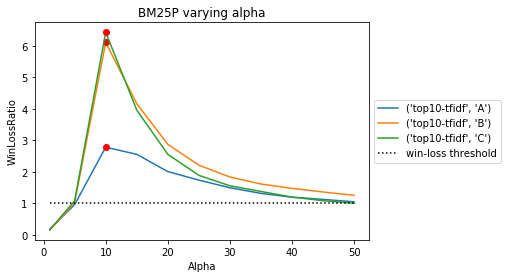

In [59]:
for baseType in baseTypes:
    plot_and_sort_WL(baseType, win_loss_dict, queryTypes)

## Todo:

- intersect qid from wins of C for alpha 10 with wins of C for alpha 40